# Biases in Indian Citizen Science Data

What systematic biases exist in India's GBIF records? We examine temporal, taxonomic, data source, and spatial precision patterns.

In [1]:
import sys; sys.path.insert(0, ".")
from _shared import *
setup_plotting()

india_df = pd.read_parquet(CACHE_DIR / "india_df.parquet")

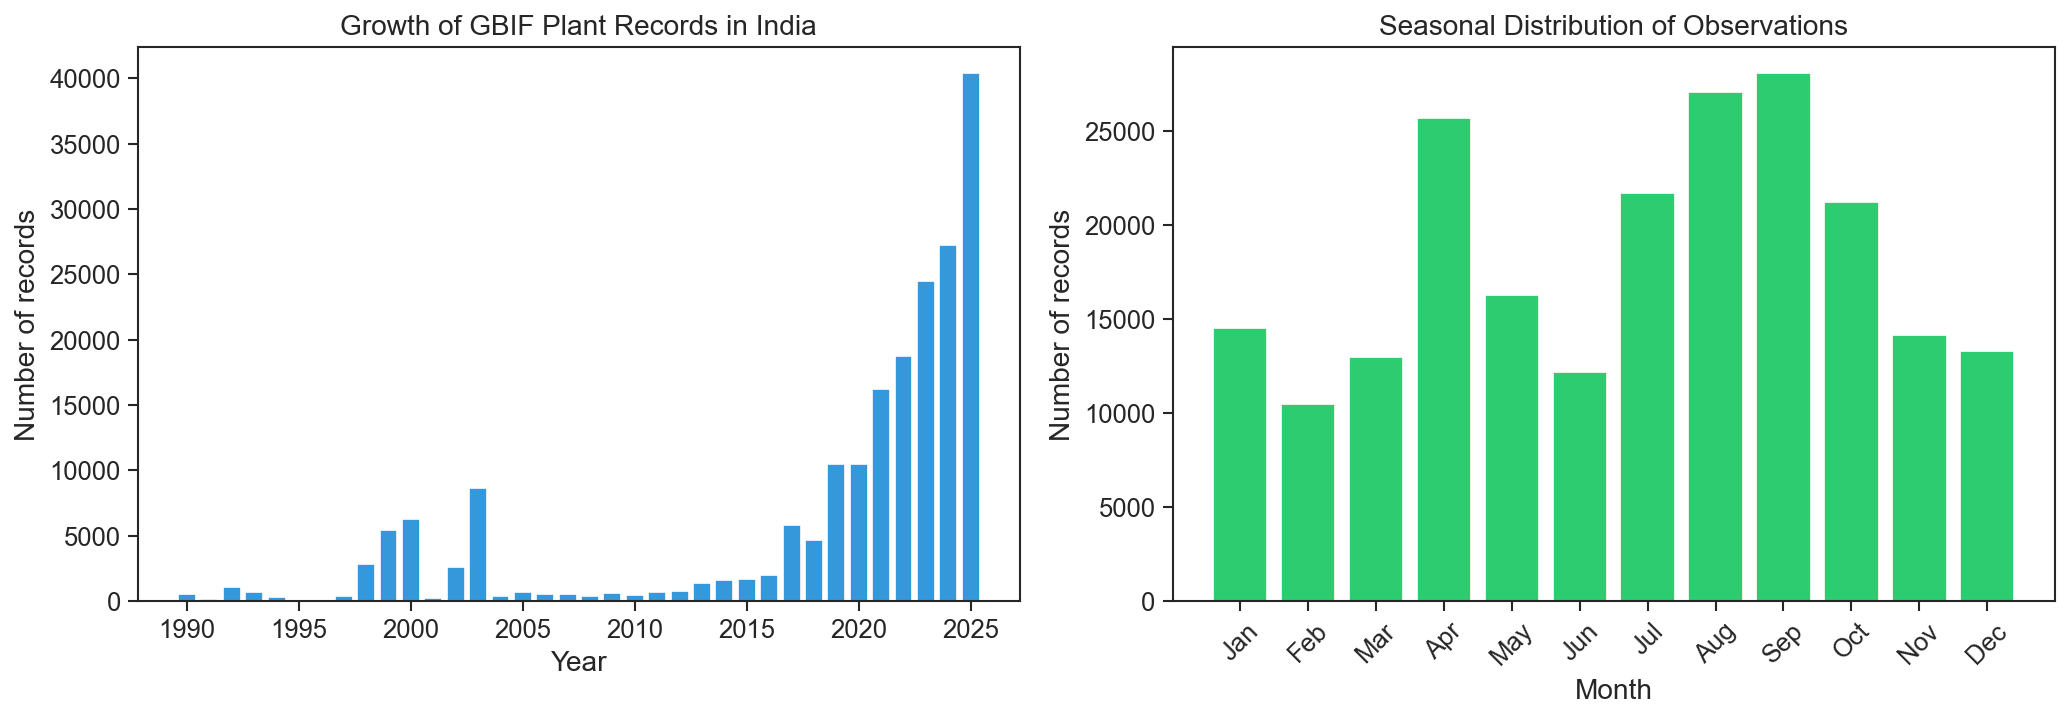

Compound annual growth rate (2020-2025): 30.9%


In [2]:
# Figure 6: Temporal patterns — annual growth + seasonality
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

year_counts = india_df.dropna(subset=["year"]).query("1990 <= year <= 2025").groupby("year").size()
axes[0].bar(year_counts.index.astype(int), year_counts.values, color="#3498db")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of records")
axes[0].set_title("Growth of GBIF Plant Records in India")

month_counts = india_df.dropna(subset=["month"]).groupby("month").size()
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
axes[1].bar(
    range(1, 13),
    [month_counts.get(float(m), 0) for m in range(1, 13)],
    color="#2ecc71",
    tick_label=month_names,
)
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Number of records")
axes[1].set_title("Seasonal Distribution of Observations")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Growth rate
recent = year_counts.loc[2020:2025]
if len(recent) >= 2:
    growth = (recent.iloc[-1] / recent.iloc[0]) ** (1 / (len(recent) - 1)) - 1
    print(f"Compound annual growth rate (2020-2025): {growth:.1%}")

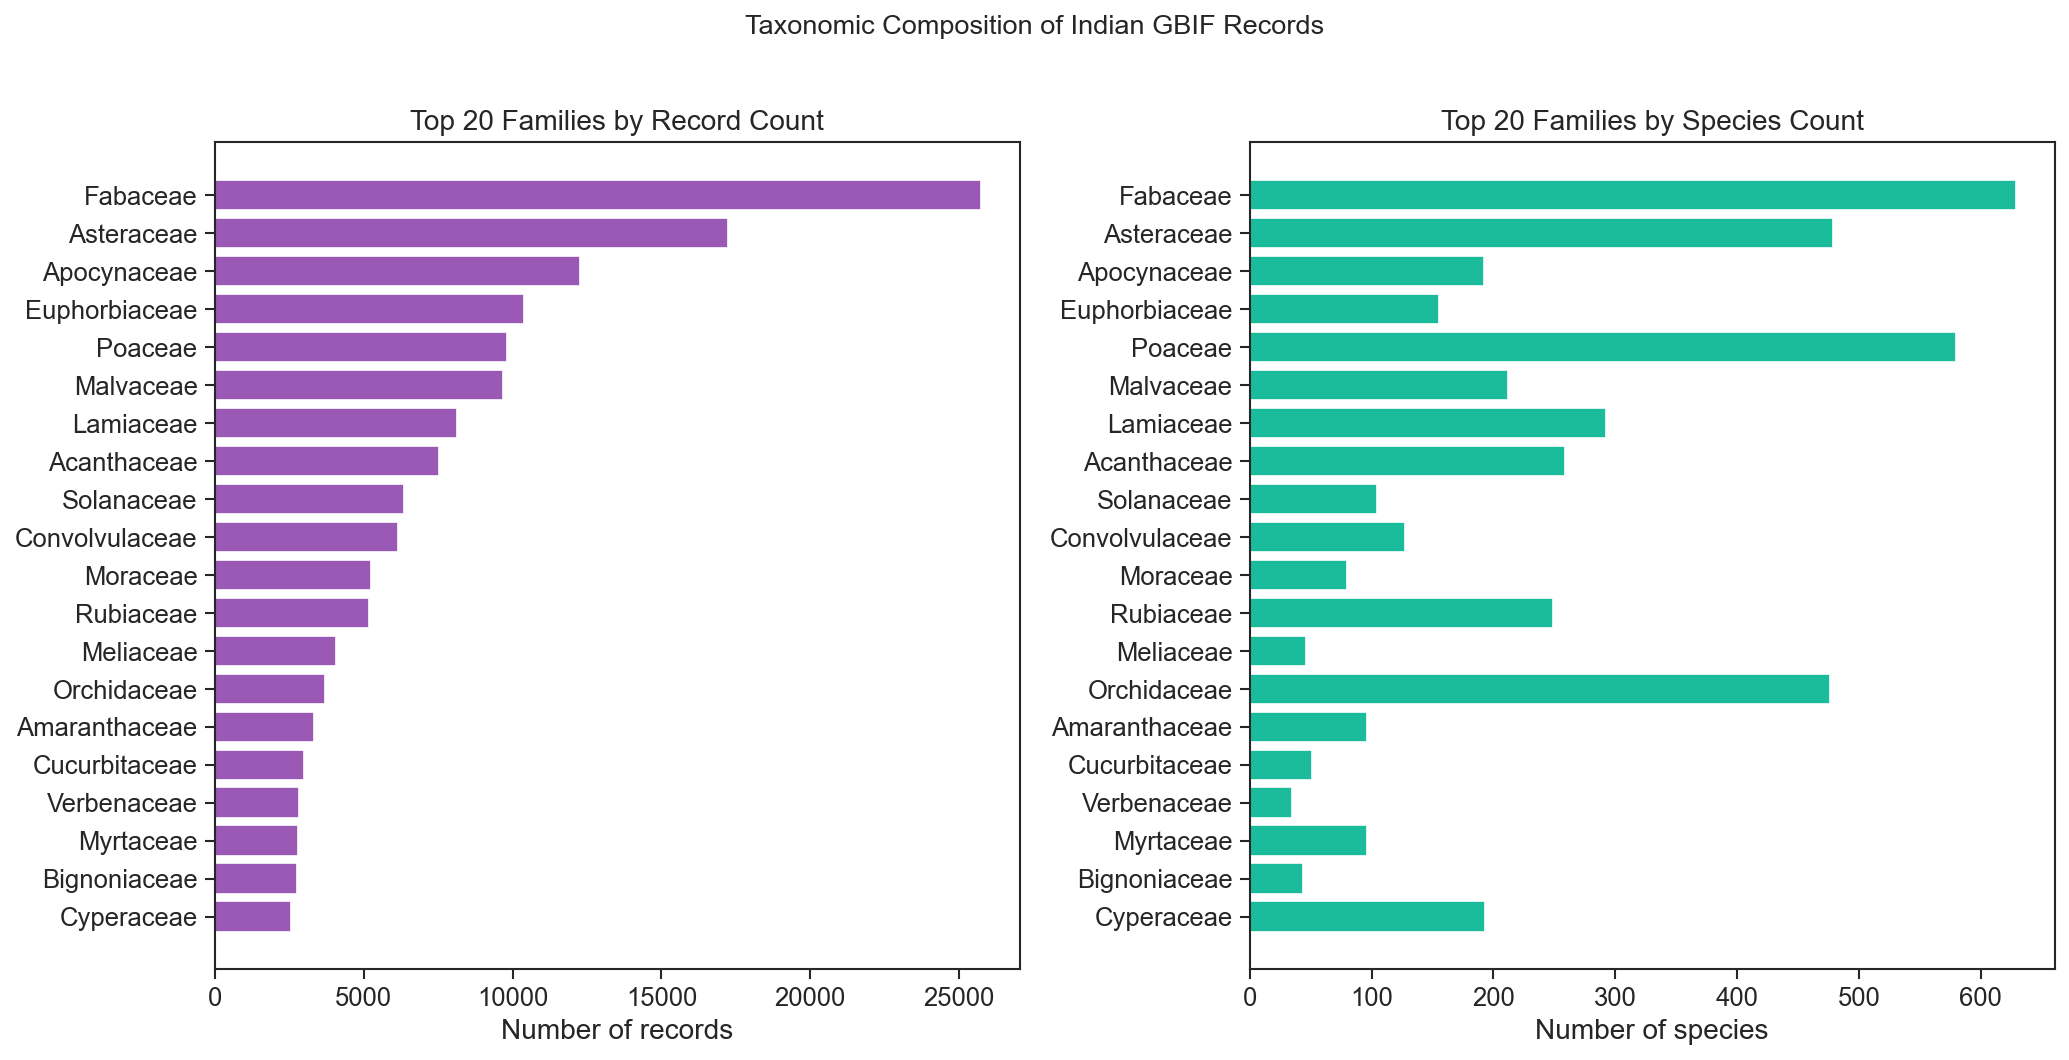

Top 5 families account for 30.9% of all records


In [3]:
# Figure 7: Taxonomic composition \u2014 top 20 families
family_counts = (
    india_df.groupby("family")
    .agg(n_records=("species", "size"), n_species=("species", "nunique"))
    .sort_values("n_records", ascending=False)
)

top_fam = family_counts.head(20)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].barh(top_fam.index[::-1], top_fam.n_records[::-1], color="#9b59b6")
axes[0].set_title("Top 20 Families by Record Count")
axes[0].set_xlabel("Number of records")

axes[1].barh(top_fam.index[::-1], top_fam.n_species[::-1], color="#1abc9c")
axes[1].set_title("Top 20 Families by Species Count")
axes[1].set_xlabel("Number of species")

fig.suptitle("Taxonomic Composition of Indian GBIF Records", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

top5_pct = family_counts.n_records.head(5).sum() / family_counts.n_records.sum()
print(f"Top 5 families account for {top5_pct:.1%} of all records")

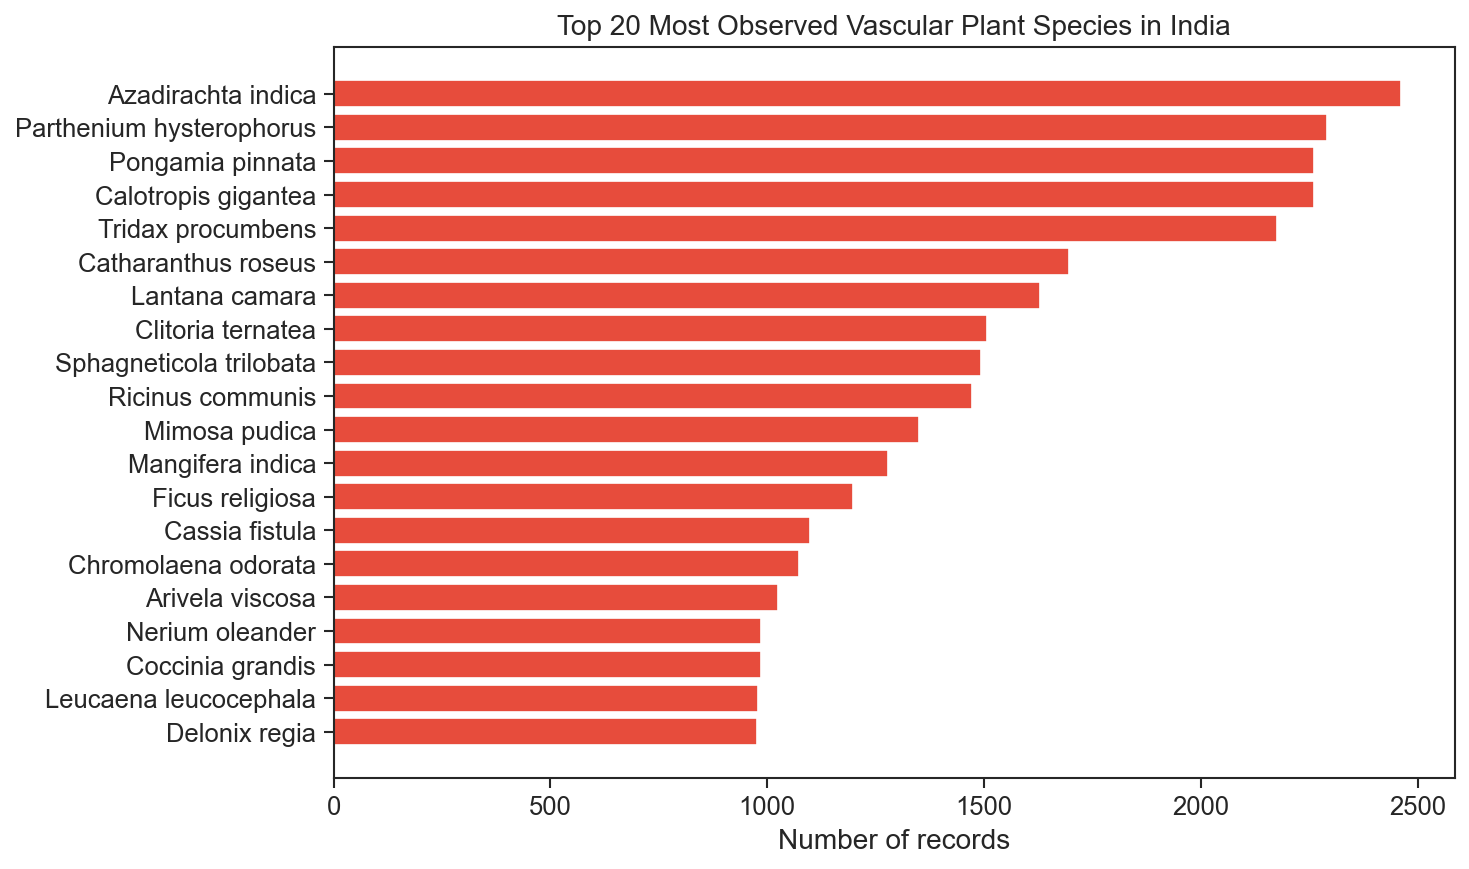

Total unique species observed: 8,881
Top 20 species account for 12.4% of records


In [4]:
# Figure 8: Top 20 most-observed species
species_counts = india_df.groupby("species").size().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
top20_sp = species_counts.head(20)
ax.barh(top20_sp.index[::-1], top20_sp.values[::-1], color="#e74c3c")
ax.set_xlabel("Number of records")
ax.set_title("Top 20 Most Observed Vascular Plant Species in India")
plt.tight_layout()
plt.show()

total_species = india_df.species.nunique()
print(f"Total unique species observed: {total_species:,}")
print(f"Top 20 species account for {top20_sp.sum() / len(india_df):.1%} of records")

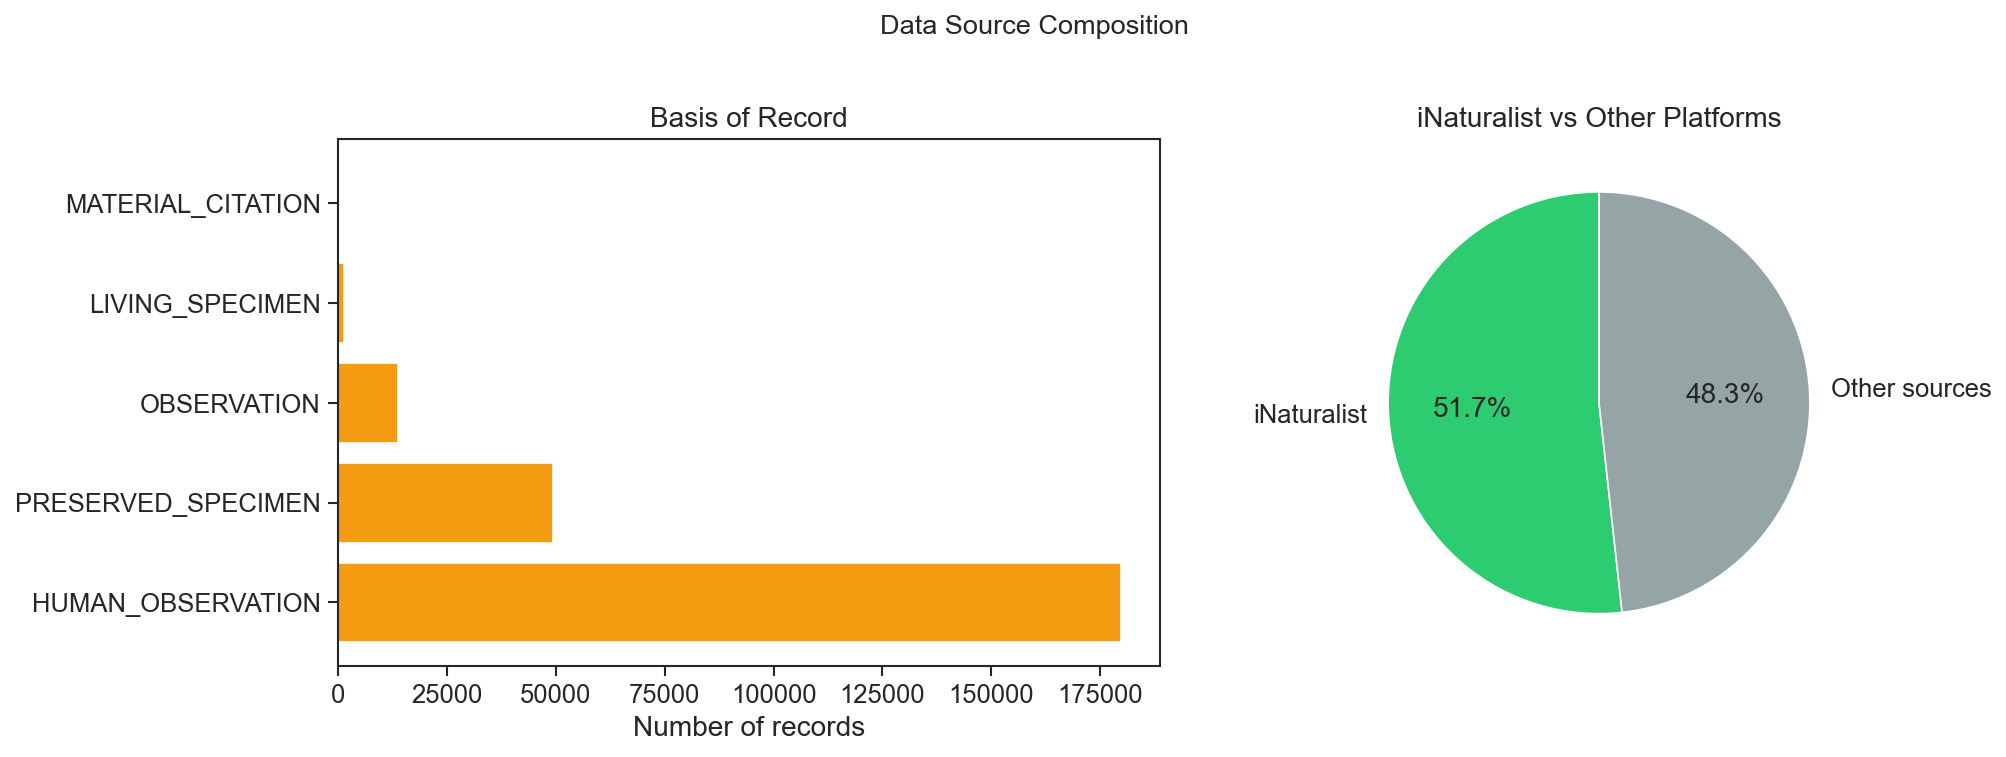

In [5]:
# Figure 9: Data source composition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Basis of record
bor_counts = india_df.basisofrecord.value_counts()
axes[0].barh(bor_counts.index, bor_counts.values, color="#f39c12")
axes[0].set_title("Basis of Record")
axes[0].set_xlabel("Number of records")

# iNaturalist vs others
is_inat = india_df.datasetkey == INAT_DATASET_KEY
platform_counts = pd.Series(
    {"iNaturalist": is_inat.sum(), "Other sources": (~is_inat).sum()}
)
axes[1].pie(
    platform_counts,
    labels=platform_counts.index,
    autopct="%1.1f%%",
    colors=["#2ecc71", "#95a5a6"],
    startangle=90,
)
axes[1].set_title("iNaturalist vs Other Platforms")

fig.suptitle("Data Source Composition", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

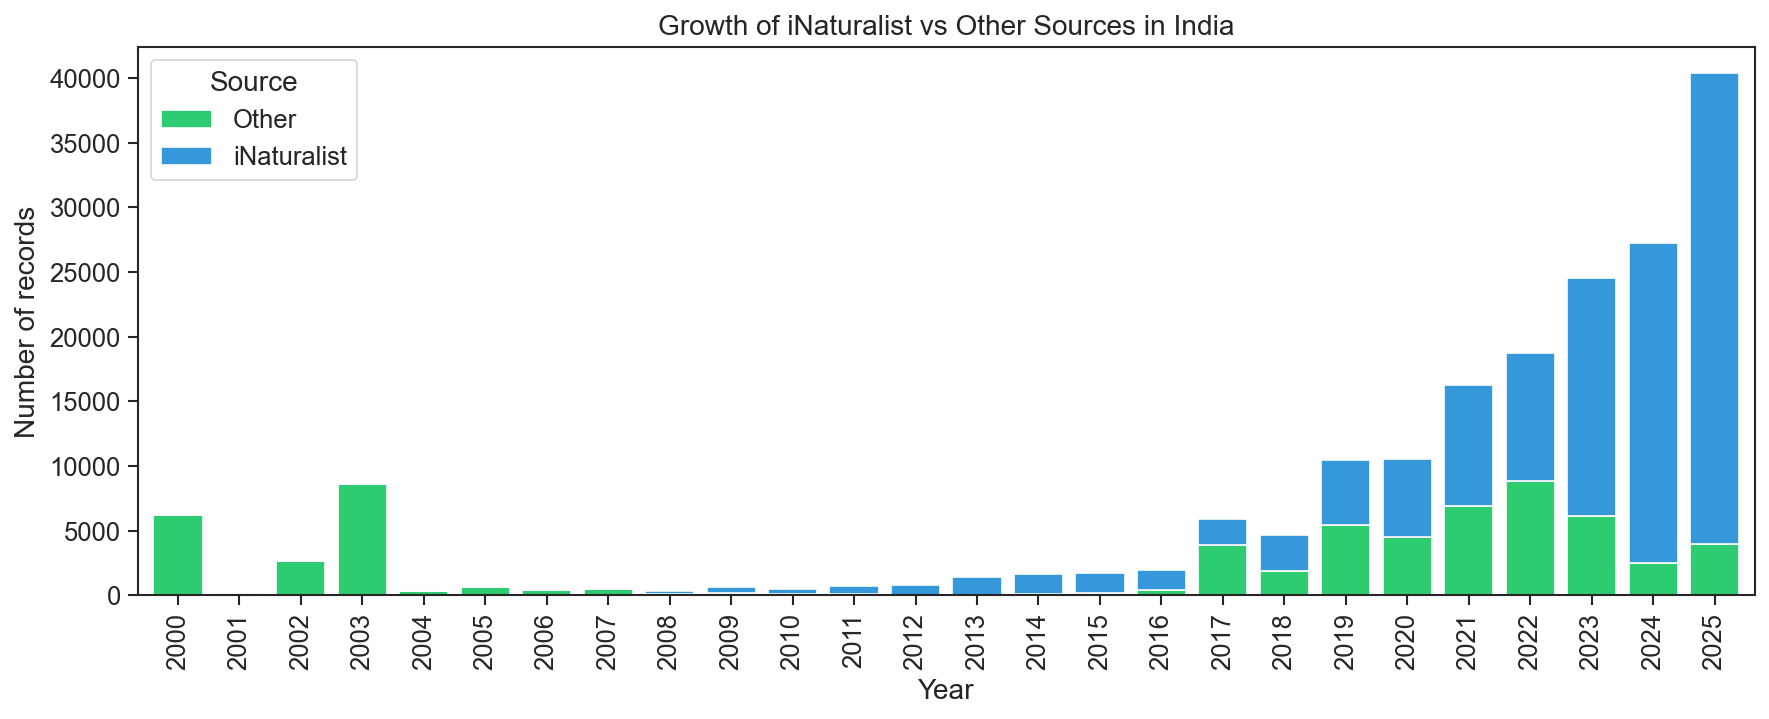

In [6]:
# Figure 10: iNaturalist vs other sources over time
india_df = india_df.assign(
    source=np.where(india_df.datasetkey == INAT_DATASET_KEY, "iNaturalist", "Other")
)

yearly_source = (
    india_df.dropna(subset=["year"])
    .query("2000 <= year <= 2025")
    .assign(year=lambda x: x.year.astype(int))
    .groupby(["year", "source"])
    .size()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(12, 5))
yearly_source.plot.bar(stacked=True, ax=ax, color=["#2ecc71", "#3498db"], width=0.8)
ax.set_xlabel("Year")
ax.set_ylabel("Number of records")
ax.set_title("Growth of iNaturalist vs Other Sources in India")
ax.legend(title="Source")
plt.tight_layout()
plt.show()

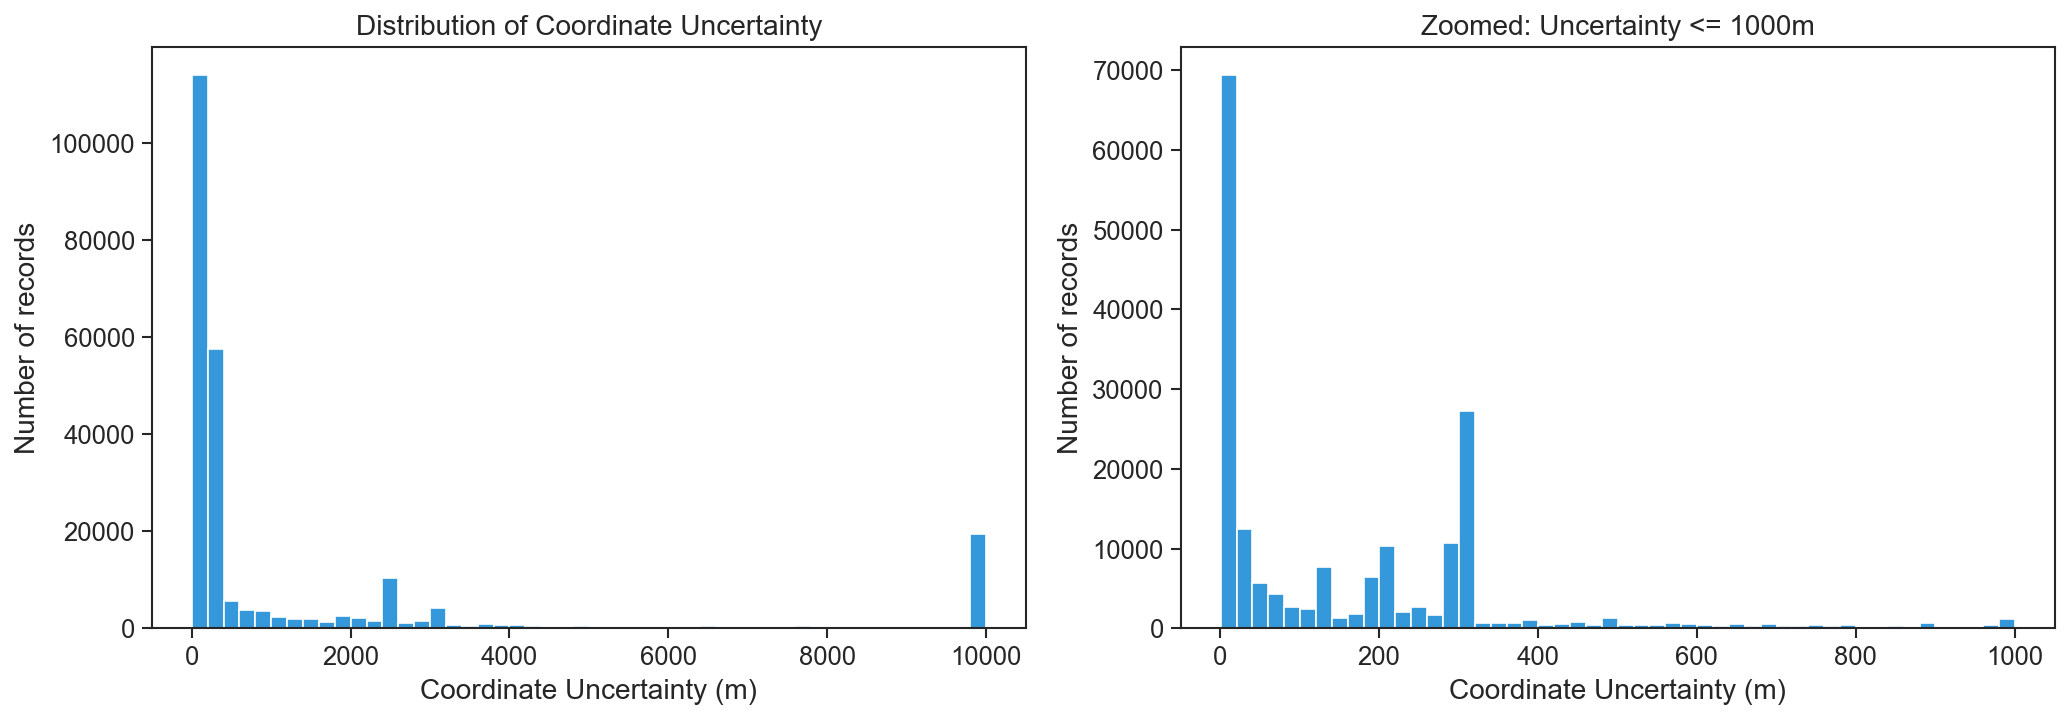

Records with uncertainty data: 244,100 (100.0%)
Median uncertainty: 212 m
Records with uncertainty <= 100m: 94,580 (38.7%)


In [7]:
# Figure 11: Coordinate uncertainty
uncertainty = india_df.coordinateuncertaintyinmeters.dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(uncertainty, bins=50, color="#3498db", edgecolor="white")
axes[0].set_xlabel("Coordinate Uncertainty (m)")
axes[0].set_ylabel("Number of records")
axes[0].set_title("Distribution of Coordinate Uncertainty")

axes[1].hist(
    uncertainty[uncertainty <= 1000], bins=50, color="#3498db", edgecolor="white"
)
axes[1].set_xlabel("Coordinate Uncertainty (m)")
axes[1].set_ylabel("Number of records")
axes[1].set_title("Zoomed: Uncertainty <= 1000m")

plt.tight_layout()
plt.show()

print(f"Records with uncertainty data: {len(uncertainty):,} ({len(uncertainty)/len(india_df):.1%})")
print(f"Median uncertainty: {uncertainty.median():.0f} m")
print(f"Records with uncertainty <= 100m: {(uncertainty <= 100).sum():,} ({(uncertainty <= 100).mean():.1%})")